In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import files
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adadelta, Adam


In [4]:
files.upload()
cars = pd.read_csv('cars_new.csv', sep=',')

Saving cars_new.csv to cars_new.csv


In [0]:
def create_dict(s):
  ret = {} #Создаём пустой словарь
  for _id, name in enumerate(s): #Проходим по всем парам - id и название
    ret.update({name: _id}) #Добавляем в словарь
  return ret

#ФУнкция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [6]:
cars[:5]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [0]:
#Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

#Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

#Запоминаем числовые параметры
#И нормируем
# years = preprocessing.scale(cars['year'])
# mileages = preprocessing.scale(cars['mileage'])
# volumes = preprocessing.scale(cars['volume'])
# powers = preprocessing.scale(cars['power'])
# без нормализации данны
years = cars['year']
mileages = cars['mileage']
volumes = cars['volume']
powers = cars['power']

In [8]:
print(marks_dict)

{'nissan': 0, 'mercedes-benz': 1, 'daewoo': 2, 'bmw': 3, 'kia': 4, 'ford': 5, 'subaru': 6, 'mazda': 7, 'mitsubishi': 8, 'suzuki': 9, 'opel': 10, 'honda': 11, 'chevrolet': 12, 'renault': 13, 'audi': 14, 'peugeot': 15, 'toyota': 16, 'volkswagen': 17, 'skoda': 18, 'chery': 19, 'hyundai': 20}


In [0]:
#Создаём пустую обучающую выборку
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [10]:
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [0]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [13]:
print(y_train_scaled[:10])

[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10119 samples
Epoch 1/5
60000/60000 [==============================] - 384s 6ms/sample - loss: 421240.3234 - val_loss: 1.6187
Epoch 2/5
60000/60000 [==============================] - 382s 6ms/sample - loss: 84125.7162 - val_loss: 1.6250
Epoch 3/5
60000/60000 [==============================] - 379s 6ms/sample - loss: 78716.3495 - val_loss: 23.9874
Epoch 4/5
60000/60000 [==============================] - 382s 6ms/sample - loss: 5415.4307 - val_loss: 1.1598
Epoch 5/5
60000/60000 [==============================] - 372s 6ms/sample - loss: 12482.8420 - val_loss: 3.9204


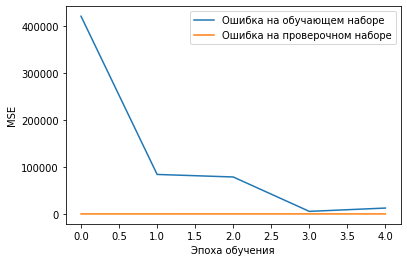

Средняя ошибка:  1036438.0
Средняя цена:  530277.0
Процент ошибки: 195.0%


In [14]:
# Обучение  сети без нормализации данных

model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=0.0001), loss='mse')

n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=5
                    , 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

predict = model.predict(x_train[n_val:])
predict = y_scaler.inverse_transform(predict).flatten()

delta = predict - y_train[n_val:]
abs_delta = abs(delta)

mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Вывод - без нормализации данных сеть не может нормально обучиться

In [0]:
year_dict = create_dict(set(cars['year']))
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [19]:
print(year_dict)

{1949: 0, 1950: 1, 1951: 2, 1959: 3, 1968: 4, 1971: 5, 1973: 6, 1974: 7, 1976: 8, 1977: 9, 1978: 10, 1979: 11, 1980: 12, 1981: 13, 1982: 14, 1983: 15, 1984: 16, 1985: 17, 1986: 18, 1987: 19, 1988: 20, 1989: 21, 1990: 22, 1991: 23, 1992: 24, 1993: 25, 1994: 26, 1995: 27, 1996: 28, 1997: 29, 1998: 30, 1999: 31, 2000: 32, 2001: 33, 2002: 34, 2003: 35, 2004: 36, 2005: 37, 2006: 38, 2007: 39, 2008: 40, 2009: 41, 2010: 42, 2011: 43, 2012: 44, 2013: 45, 2014: 46, 2015: 47, 2016: 48, 2017: 49, 2018: 50, 2019: 51}


In [29]:
print(car[3])

2018


In [0]:
#Создаём пустую обучающую выборку
# Где год нормализован словарем и ohe
x_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        to_ohe(car[3], year_dict) + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  x_train.append(x_tr)

x_train = np.array(x_train, dtype=np.float)

Train on 60000 samples, validate on 10119 samples
Epoch 1/5
60000/60000 [==============================] - 315s 5ms/sample - loss: 0.1831 - val_loss: 0.1787
Epoch 2/5
60000/60000 [==============================] - 307s 5ms/sample - loss: 0.0905 - val_loss: 0.1099
Epoch 3/5
60000/60000 [==============================] - 307s 5ms/sample - loss: 0.0716 - val_loss: 0.1040
Epoch 4/5
60000/60000 [==============================] - 305s 5ms/sample - loss: 0.0616 - val_loss: 0.0947
Epoch 5/5
60000/60000 [==============================] - 304s 5ms/sample - loss: 0.0620 - val_loss: 0.1036


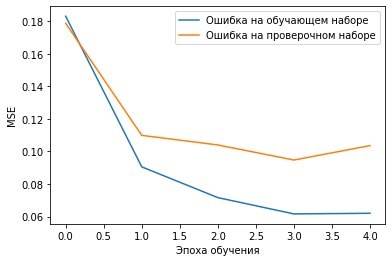

Средняя ошибка:  70653.0
Средняя цена:  530277.0
Процент ошибки: 13.0%


In [32]:
# Обучение  сети когда год выпуска нормализован как словарь и ohe

model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=0.0001), loss='mse')

n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=5
                    , 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

predict = model.predict(x_train[n_val:])
predict = y_scaler.inverse_transform(predict).flatten()

delta = predict - y_train[n_val:]
abs_delta = abs(delta)

mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")